# Vienna supermarkets

[One of the reasons given for high prices in Viennese supermarkets is the high density of supermarkets.](https://www.wienerzeitung.at/a/teure-produkte-in-oesterreichs-supermaerkten). So let's take a look at that! 

This notebook is an emulation of [this post on the /r/wien subreddit](https://www.reddit.com/r/wien/comments/1i2ncm7/superm%C3%A4rkte_in_wien/), by user [/u/dwarfmud](https://www.reddit.com/user/dwarfmud/).

First, we have to import some libraries we'll be using:
- `json` to parse OpenStreetMap tags
- `geopandas`, `pandas` and `numpy` to handle and process geographical data
- `pyrosm` to download a map of Vienna and query it
- `sklearn` is only used to construct a pairwise distance matrix

In [1]:
import json
import random

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyrosm import get_data, OSM
from scipy.spatial import KDTree
from shapely.geometry import box, Point, Polygon
from sklearn.metrics import pairwise_distances

I'll also set a few display options.

In [2]:
pd.options.display.max_columns = 100
pd.options.display.max_columns = 50

## Population data

First I'll download the [population density data for Vienna from the Vienna government data portal](https://www.data.gv.at/katalog/dataset/dc56ea9e-57be-47d5-ab50-d1e74fda7118).

In [3]:
population_df = pd.read_csv(
    "https://www.wien.gv.at/gogv/l9ogdviebezbizpopden2002f",
    header=1,
    sep=";",
    encoding="utf8",
    encoding_errors="ignore",
    thousands=".",
    decimal=",",
)

Let's take a look:

In [4]:
population_df.head(10)

,NUTS,DISTRICT_CODE,SUB_DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16
0,AT13,90000,90000,2002,20020101,1571123,414.87,3787.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT13,90000,90000,2003,20030101,1592846,414.87,3839.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AT13,90000,90000,2004,20040101,1610410,414.87,3881.71,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,AT13,90000,90000,2005,20050101,1632569,414.87,3935.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,AT13,90000,90000,2006,20060101,1652449,414.87,3983.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,AT13,90000,90000,2007,20070101,1661246,414.87,4004.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,AT13,90000,90000,2008,20080101,1671221,414.87,4028.29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,AT13,90000,90000,2009,20090101,1680135,414.87,4049.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,AT13,90000,90000,2010,20100101,1689995,414.87,4073.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,AT13,90000,90000,2011,20110101,1702855,414.87,4104.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


I'm only interested in the data for the most recent year (2024, as of the time of writing). I'll also extract the district number from the column `DISTRICT_CODE` as text.

In [5]:
max_year = population_df["REF_YEAR"].max()
population_df = (
    population_df.loc[population_df["REF_YEAR"] == max_year].reset_index(drop=True)
)[
    [
        "DISTRICT_CODE",
        "REF_YEAR",
        "REF_DATE",
        "POP_VALUE",
        "AREA",
        "POP_DENSITY",
    ]
]
population_df["DISTRICT_CODE"] = population_df["DISTRICT_CODE"].apply(
    lambda x: str(x)[1:-2].lstrip("0")
)
population_df

,DISTRICT_CODE,REF_YEAR,REF_DATE,POP_VALUE,AREA,POP_DENSITY
0,,2024,20240101,2005760,414.87,4834.66
1,1,2024,20240101,16538,2.87,5764.83
2,2,2024,20240101,110100,19.24,5721.86
3,3,2024,20240101,98398,7.40,13301.09
4,4,2024,20240101,33155,1.78,18676.68
5,5,2024,20240101,54400,2.01,27042.63
6,6,2024,20240101,31386,1.46,21570.49
7,7,2024,20240101,31513,1.61,19594.61
8,8,2024,20240101,24499,1.09,22477.27
9,9,2024,20240101,41631,2.97,14029.53


## Geodata

Now I'll download the district borders of Vienna, and set the correct coordinate reference system.

In [6]:
vienna_gdf = gpd.read_file(
    "https://data.wien.gv.at/daten/geo?service=WFS&request=GetFeature&version=1.1.0&typeName=ogdwien:BEZIRKSGRENZEOGD&srsName=EPSG:31256"
).set_crs("EPSG:31256").to_crs(crs="wgs84")

C:\Users\max\anaconda3\envs\statsforge\Lib\site-packages\pyogrio\geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


In [7]:
vienna_gdf.head()

,gml_id,NAMEK,BEZNR,BEZ_RZ,NAMEK_NUM,NAMEK_RZ,NAMEG,LABEL,BEZ,DISTRICT_CODE,STATAUSTRIA_BEZ_CODE,STATAUSTRIA_GEM_CODE,FLAECHE,UMFANG,AKT_TIMESTAMP,SE_SDO_ROWID,SE_ANNO_CAD_DATA,geometry
0,BEZIRKSGRENZEOGD.13767,Döbling,19.0,XIX,"19., Döbling",XIX. Döbling,DÖBLING,XIX.,19,1190.0,919.0,91901.0,2.494388e+07,23727.16,2024-12-04,13767.0,None,"POLYGON ((16.31993 48.24024, 16.31993 48.24024..."
1,BEZIRKSGRENZEOGD.13768,Josefstadt,8.0,VIII,"8., Josefstadt",VIII. Josefstadt,JOSEFSTADT,VIII.,08,1080.0,908.0,90801.0,1.089946e+06,4170.30,2024-12-04,13768.0,None,"POLYGON ((16.34915 48.21516, 16.34895 48.21518..."
2,BEZIRKSGRENZEOGD.13769,Brigittenau,20.0,XX,"20., Brigittenau",XX. Brigittenau,BRIGITTENAU,XX.,20,1200.0,920.0,92001.0,5.710474e+06,11659.89,2024-12-04,13769.0,None,"POLYGON ((16.37361 48.26127, 16.37354 48.26136..."
3,BEZIRKSGRENZEOGD.13770,Penzing,14.0,XIV,"14., Penzing",XIV. Penzing,PENZING,XIV.,14,1140.0,914.0,91401.0,3.376080e+07,40196.58,2024-12-04,13770.0,None,"POLYGON ((16.20914 48.26411, 16.20896 48.26417..."
4,BEZIRKSGRENZEOGD.13771,Rudolfsheim-Fünfhaus,15.0,XV,"15., Rudolfsheim-Fünfhaus",XV. Rudolfsheim-Fünfhaus,RUDOLFSHEIM-FÜNFHAUS,XV.,15,1150.0,915.0,91501.0,3.916785e+06,9710.43,2024-12-04,13771.0,BA900C000108000094F0F6F0A20390F69586F708E686B3...,"POLYGON ((16.32732 48.205, 16.32535 48.20531, ..."


In [8]:
len(vienna_gdf)

23

As expected, 23 districts.

In [9]:
vienna_gdf["BEZNR"] = vienna_gdf["BEZNR"].apply(lambda x: str(round(x, None)))

I'll change the column `BEZNR` to also be text.

<Axes: >

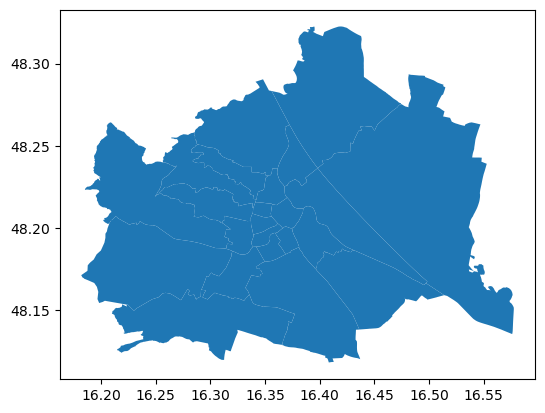

In [10]:
vienna_gdf.plot()

This looks good!

## Supermarkt data

Finally, we need data on the supermarkets in Vienna. For this, I'll download and query [OpenStreetMap](https://www.openstreetmap.org) data using [pyrosm](https://pyrosm.readthedocs.io/en/latest/).

In [11]:
vienna_data_path = get_data("wien")
osm = OSM(vienna_data_path)

I've downloaded and instantiated the data, now it's time to query it - we're interested in all points `shop` of type `supermarket`.

In [12]:
supermarkets = osm.get_pois(
    custom_filter={
        "shop": [
            "supermarket",
        ]
    }
)

Let's transform the query results into a dataframe and take a look.

In [13]:
supermarkets_gdf = gpd.GeoDataFrame(supermarkets)
supermarkets_gdf.head()

,visible,tags,lon,changeset,id,lat,version,timestamp,addr:city,addr:country,addr:housenumber,addr:housename,addr:postcode,addr:place,addr:street,email,name,opening_hours,operator,phone,ref,website,alcohol,organic,shop,supermarket,geometry,osm_type,url
0,False,"{""atm"":""yes"",""brand"":""Eurospar"",""brand:wikidat...",16.287668,0.0,15079903,48.196968,0,0,Wien,AT,180,None,1140,None,Hütteldorfer Straße,None,Eurospar,Mo-Fr 07:30-19:50; Sa 07:40-18:00,SPAR Österreichische Warenhandels-AG,None,None,None,None,None,supermarket,None,POINT (16.28767 48.19697),node,NaN
1,False,"{""brand"":""Billa Plus"",""brand:wikidata"":""Q11543...",16.298906,0.0,15080180,48.197762,0,0,Wien,AT,130B,None,1140,None,Hütteldorfer Straße,None,Billa Plus,Mo-Fr 07:40-20:00; Sa 07:40-18:00,None,None,None,https://www.billa.at,None,None,supermarket,None,POINT (16.29891 48.19776),node,NaN
2,False,"{""brand"":""Billa Plus"",""brand:wikidata"":""Q11543...",16.279953,0.0,43749523,48.191101,0,0,Wien,AT,65-67,None,1130,None,Amalienstraße,None,Billa Plus,"Mo-Fr 07:15-19:30,Sa 07:15-18:00",MERKUR Warenhandels AG,None,None,https://www.billa.at,None,None,supermarket,None,POINT (16.27995 48.1911),node,NaN
3,False,"{""brand"":""Billa"",""brand:wikidata"":""Q537781"",""b...",16.221996,0.0,49494265,47.977585,0,0,None,None,None,None,None,None,None,None,Billa Plus,Mo-Fr 07:40-20:00; Sa 07:40-18:00; PH off,None,+43 59915 02041,None,https://www.billa.at,None,None,supermarket,None,POINT (16.222 47.97758),node,NaN
4,False,"{""brand"":""Billa"",""brand:wikidata"":""Q537781"",""b...",16.362995,0.0,61272892,48.332001,0,0,Bisamberg,None,6-8,None,2102,None,Josef-Dabsch-Straße,None,Billa,Mo-Fr 07:15-19:30; Sa 07:15-18:00,None,059915 03731,None,None,None,None,supermarket,None,POINT (16.363 48.332),node,NaN


In [14]:
len(supermarkets_gdf)

1437

We found 1437 supermarkets.

<Axes: >

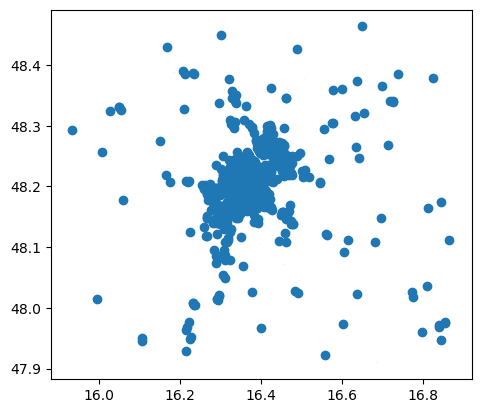

In [15]:
supermarkets_gdf.plot()

In [16]:
supermarkets_gdf["brand"] = supermarkets_gdf["tags"].apply(
    lambda x: json.loads(x if isinstance(x, str) else "{}").get("brand", "Unbekannt")
)

Now I'll extract the brand from the `tags` column.

In [17]:
supermarkets_gdf["brand"].value_counts()

brand
Billa              420
Unbekannt          275
Hofer              167
Spar               153
Lidl                74
PENNY               62
Penny               58
Billa Plus          53
Eurospar            40
SPAR Gourmet        34
Interspar           24
ETSAN               20
ADEG                20
denn's Biomarkt      9
Nah & Frisch         9
Denns BioMarkt       7
Mix Markt            3
SE&PAS               2
Unimarkt             2
BILLA PLUS           1
Spar Gourmet         1
Gencer               1
Bedronka             1
Müller               1
Name: count, dtype: int64

Let's standardize some spelling of names, and count "Spar Gourmet" as "Spar", etc.

In [18]:
supermarkets_gdf["brand"] = supermarkets_gdf["brand"].replace(
    {
        "Billa Plus": "Billa",
        "BILLA PLUS": "Billa",
        "PENNY": "Penny",
        "Spar Gourmet": "Spar",
        "Interspar": "Spar",
        "SPAR Gourmet": "Spar",
        "Eurospar": "Spar",
        "Denns BioMarkt": "denn's Biomarkt"
    }
)
supermarkets_gdf["brand"].value_counts()

brand
Billa              474
Unbekannt          275
Spar               252
Hofer              167
Penny              120
Lidl                74
ADEG                20
ETSAN               20
denn's Biomarkt     16
Nah & Frisch         9
Mix Markt            3
SE&PAS               2
Unimarkt             2
Gencer               1
Bedronka             1
Müller               1
Name: count, dtype: int64

There's also the column "operator"; let's take a look:

In [19]:
supermarkets_gdf["operator"].value_counts()

operator
Rewe International    75
Billa                 26
Spar                  25
Hofer                 16
Billa AG              11
                      ..
Wolfgang Gromes        1
Arge Rosenauerwald     1
Jelicic GmbH           1
Kamal Ibrahim          1
Eurospar               1
Name: count, Length: 73, dtype: int64

This seems less interesting, as I'm more interested in the brand. I'll use the "brand" column going forward.

## Merge

Now to merge the population data, district borders, and supermarket data.

First I'll use a ['within' inner spatial join](https://geopandas.org/en/stable/gallery/spatial_joins.html) to determine which district the supermarkets are in, and drop those that aren't within one of Vienna's 23 districts.

In [20]:
supermarkets_gdf = gpd.sjoin(supermarkets_gdf, vienna_gdf[['geometry', 'BEZNR']], how='inner', predicate='within')

Next I'll merge the population data on the district number (both previously transformed to text).

In [21]:
full_gdf = supermarkets_gdf.merge(
    population_df, how="left", left_on="BEZNR", right_on="DISTRICT_CODE"
)

In [22]:
len(full_gdf)

1039

We have 1039 data points (supermarkets) remaining. But are they actually all points?

In [23]:
full_gdf.geom_type.value_counts()

Point      862
Polygon    177
Name: count, dtype: int64

177 are polygons, presumably the actual outline of the building. Let's take a look at one.

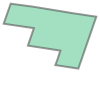

In [24]:
full_gdf[full_gdf.geom_type == "Polygon"].iloc[0]["geometry"]

Let's turn these into points by taking a [representative point](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.representative_point.html).

In [25]:
full_gdf["geometry"] = full_gdf["geometry"].representative_point()
full_gdf.geom_type.value_counts()

Point    1039
Name: count, dtype: int64

Now they're all points.

## Pairwise distances

We can calculate the pairwise distances for these ~1000 supermarkets; it'll be approximately half a million calculations, which is manageable.

In [26]:
coordinates = np.radians(np.array([geom.coords[0] for geom in full_gdf.geometry]))
distance_matrix = pairwise_distances(coordinates, metric='haversine') * 6378 # radius of earth
distance_matrix[:5, :5]

array([[ 0.        ,  1.25386185,  1.06329769,  9.90784814, 11.11221635],
       [ 1.25386185,  0.        ,  2.22662048,  8.68152488,  9.86922047],
       [ 1.06329769,  2.22662048,  0.        , 10.90717195, 12.08323765],
       [ 9.90784814,  8.68152488, 10.90717195,  0.        ,  1.4229094 ],
       [11.11221635,  9.86922047, 12.08323765,  1.4229094 ,  0.        ]])

## Per-district counts and densities

Next, I'll add up the totals per district, and divide this by population and area.

In [27]:
per_district = full_gdf["BEZNR"].value_counts().rename("district_total")
per_district_df = population_df.merge(per_district, how="inner", left_on="DISTRICT_CODE", right_index=True)
per_district_df["per_area"] = per_district_df["district_total"] / per_district_df["AREA"]
per_district_df["per_capita"] = per_district_df["district_total"] / per_district_df["POP_VALUE"]

## Plots

### Histogram of brands

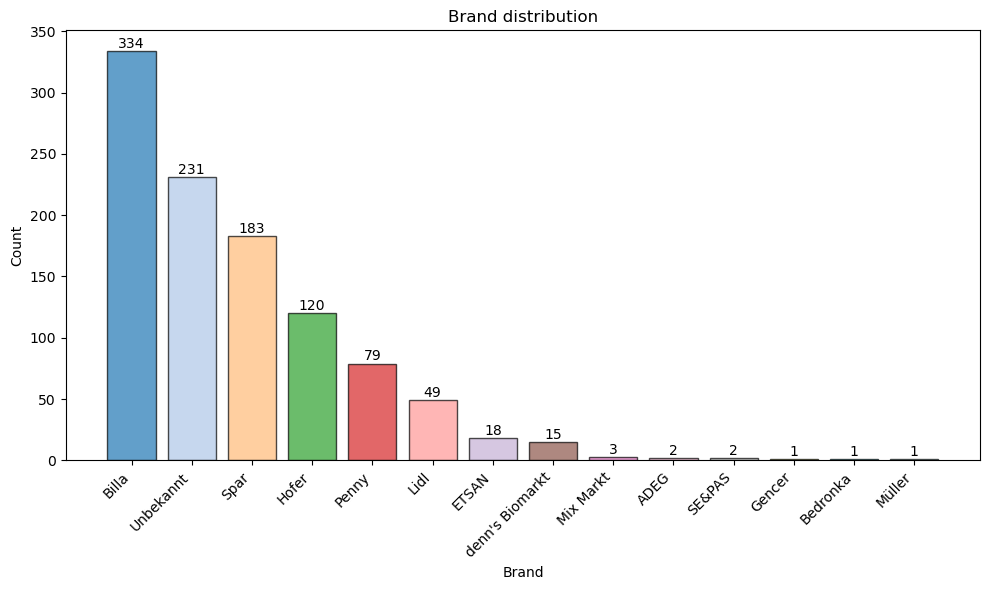

In [28]:
brand_counts = supermarkets_gdf["brand"].value_counts()
plt.figure(figsize=(10, 6))
colors = plt.get_cmap("tab20", len(brand_counts))
color_map = {brand: colors(i) for i, brand in enumerate(brand_counts.index)}
full_gdf["color"] = full_gdf["brand"].map(color_map)
bars = plt.bar(
    brand_counts.index,
    brand_counts.values,
    color=colors(np.arange(len(brand_counts))),
    edgecolor="black",
    alpha=0.7,
)
plt.xlabel("Brand")
plt.ylabel("Count")
plt.title("Brand distribution")
plt.xticks(rotation=45, ha="right")
for i, bar in enumerate(bars):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.05,
        str(int(bar.get_height())),
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

### Locations

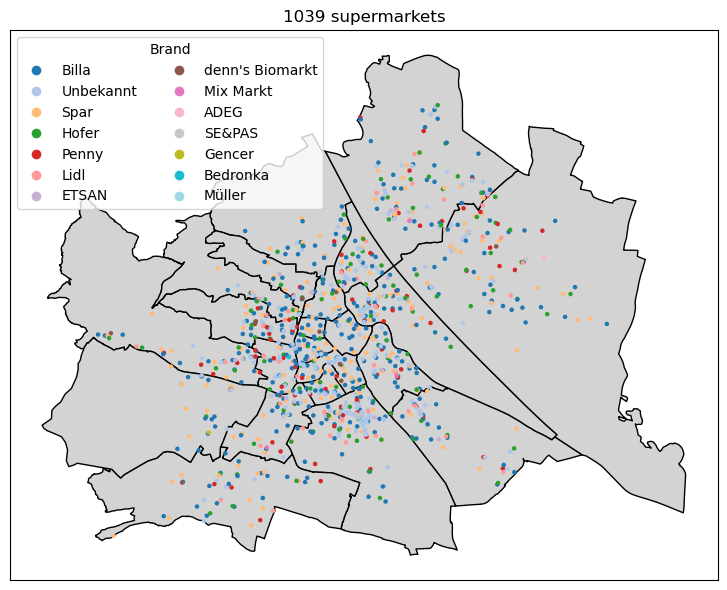

In [29]:
from matplotlib.lines import Line2D

fig, ax = plt.subplots(figsize=(10, 6))
vienna_gdf.plot(ax=ax, color="lightgray", edgecolor="black", legend=True)
full_gdf.plot(ax=ax, marker="o", color=full_gdf["color"], markersize=5)
plt.title(f"{len(full_gdf)} supermarkets")
ax.set_xticks([])
ax.set_yticks([])
legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color_map[brand],
        markersize=8,
        label=brand,
    )
    for brand in brand_counts.index
]
plt.legend(handles=legend_handles, title="Brand", loc="upper left", ncol=2)
plt.tight_layout()
plt.show()

### Number per district

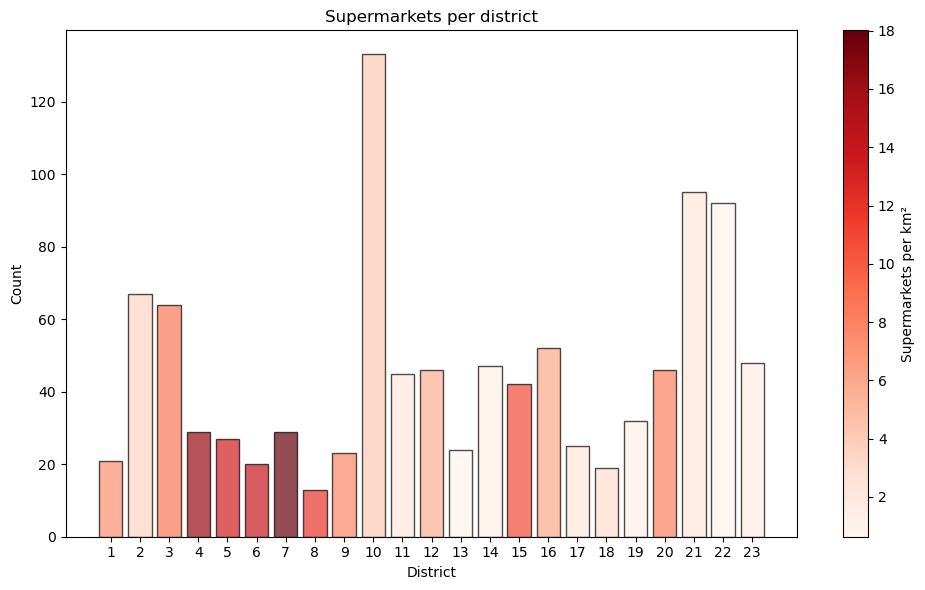

In [30]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    per_district_df["DISTRICT_CODE"],
    per_district_df["district_total"],
    edgecolor="black",
    alpha=0.7,
)
norm = plt.Normalize(
    per_district_df["per_area"].min(), per_district_df["per_area"].max()
)
for bar, area_value in zip(bars, per_district_df["per_area"]):
    bar.set_facecolor(plt.cm.Reds(norm(area_value)))
cbar = plt.colorbar(
    plt.cm.ScalarMappable(
        norm=norm,
        cmap="Reds",
    ),
    ax=ax,
)
cbar.set_label("Supermarkets per km²")
ax.set_xlabel("District")
ax.set_ylabel("Count")
ax.set_title("Supermarkets per district")
plt.tight_layout()
plt.show()

### People per supermarket

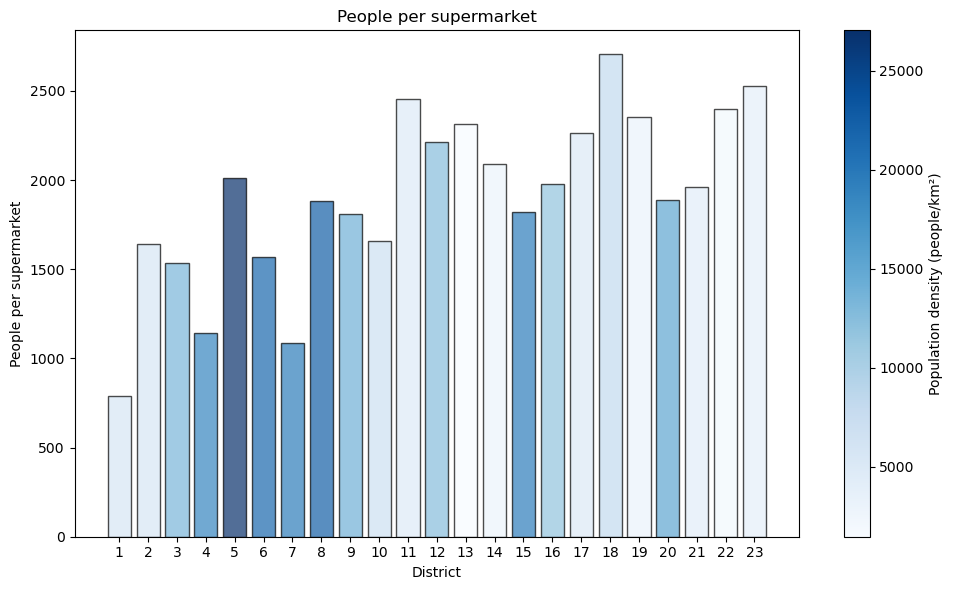

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(
    per_district_df["DISTRICT_CODE"],
    1 / per_district_df["per_capita"],
    edgecolor="black",
    alpha=0.7,
)
norm = plt.Normalize(
    per_district_df["POP_DENSITY"].min(), per_district_df["POP_DENSITY"].max()
)
for bar, density_value in zip(bars, per_district_df["POP_DENSITY"]):
    bar.set_facecolor(plt.cm.Blues(norm(density_value)))
cbar = plt.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="Blues"),
    ax=ax,
)
cbar.set_label("Population density (people/km²)")
ax.set_xlabel("District")
ax.set_ylabel("People per supermarket")
ax.set_title("People per supermarket")
plt.tight_layout()
plt.show()

### Minimum pairwise distance distribution

The distribution of the distance between the two closest supermarkets. I need to fill the diagonal (distance to self) with a large value, because otherwise I get the non-informative result that each supermarket is closest to itself. 

In [32]:
np.fill_diagonal(distance_matrix, np.inf)
full_gdf["min_distance_to_next"] = np.min(distance_matrix, axis=0)

<Figure size 1000x600 with 0 Axes>

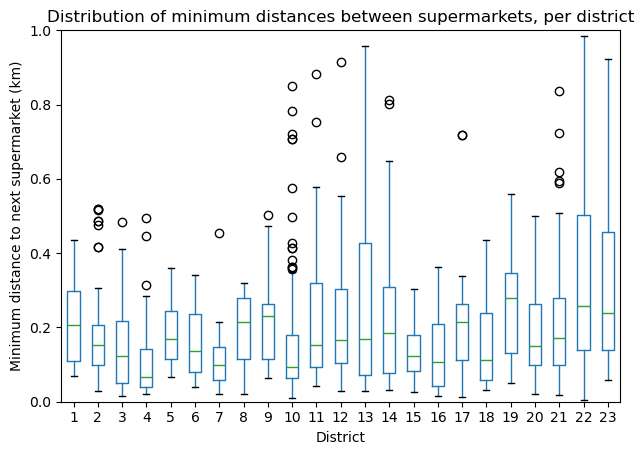

In [33]:
full_gdf["DISTRICT_CODE_INT"] = full_gdf["DISTRICT_CODE"].astype(int)
plt.figure(figsize=(10, 6))
full_gdf.boxplot(column='min_distance_to_next', by='DISTRICT_CODE_INT', grid=False)
plt.ylim(0, 1)
plt.title('Distribution of minimum distances between supermarkets, per district')
plt.suptitle('')
plt.xlabel('District')
plt.ylabel('Minimum distance to next supermarket (km)')
plt.tight_layout()
plt.show()

### One specific district

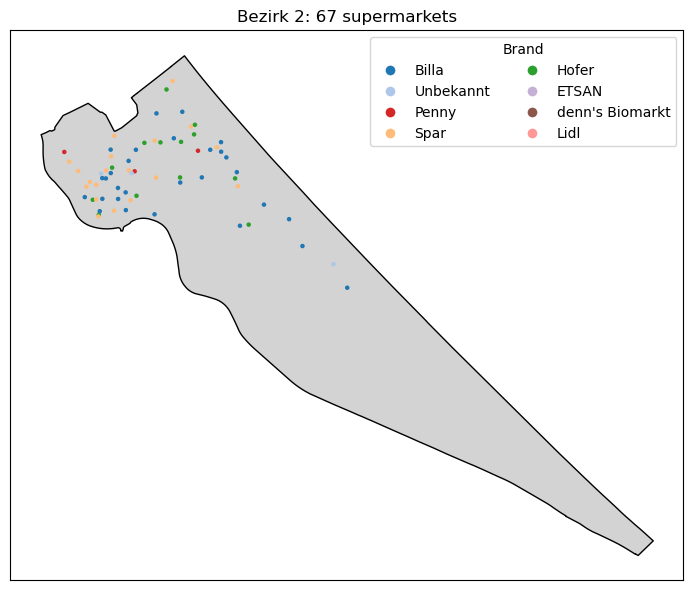

In [34]:
bezirk = '2'

fig, ax = plt.subplots(figsize=(10, 6))
vienna_gdf.loc[vienna_gdf['BEZNR'] == bezirk].plot(ax=ax, color="lightgray", edgecolor="black", legend=True)
full_gdf.loc[full_gdf['BEZNR'] == bezirk].plot(ax=ax, marker="o", color=full_gdf["color"], markersize=5)
plt.title(f"Bezirk {bezirk}: {len(full_gdf.loc[full_gdf['BEZNR'] == bezirk])} supermarkets")
ax.set_xticks([])
ax.set_yticks([])
legend_handles = [
    Line2D(
        [0],
        [0],
        marker="o",
        color="w",
        markerfacecolor=color_map[brand],
        markersize=8,
        label=brand,
    )
    for brand in full_gdf.loc[full_gdf['BEZNR'] == bezirk]["brand"].unique()
]
plt.legend(handles=legend_handles, title="Brand", loc="upper right", ncol=2)
plt.tight_layout()
plt.show()

### Minimum distance to a non-chain store

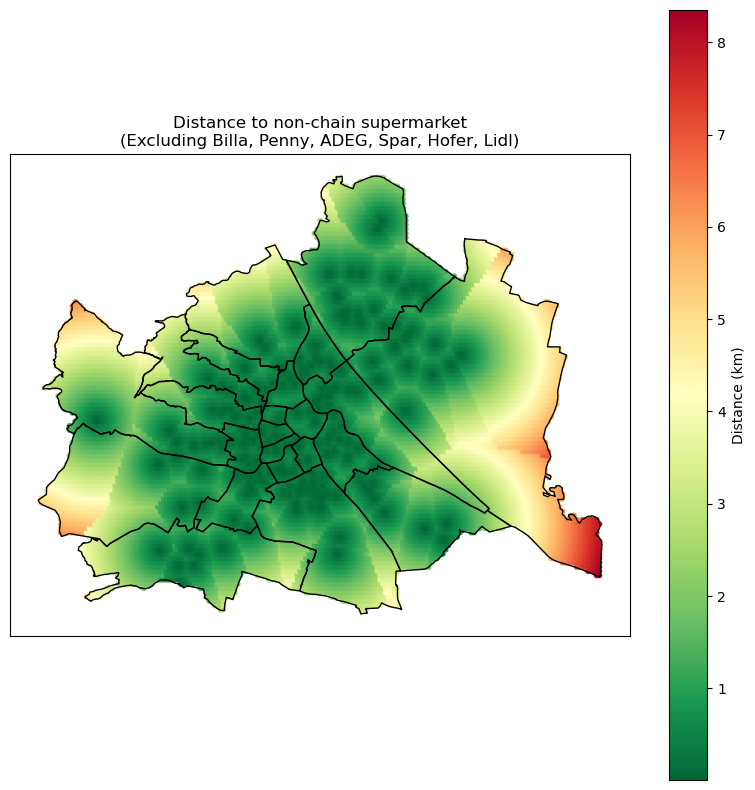

In [36]:
def generate_grid(gdf, grid_size=0.01):
    bounds = gdf.total_bounds
    x_min, y_min, x_max, y_max = bounds
    x_coords = np.arange(x_min, x_max, grid_size)
    y_coords = np.arange(y_min, y_max, grid_size)

    points = []
    for x in x_coords:
        for y in y_coords:
            point = Point(x, y)
            if gdf.geometry.union_all().contains(point):
                points.append(point)

    return points


def haversine_distance(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return 6378 * c


def ckdnearest(gdA, gdB):
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = KDTree(nB)
    dist, idx = btree.query(nA, k=1)
    haversine_dists = np.array(
        [
            haversine_distance(nA[i][1], nA[i][0], nB[idx[i]][1], nB[idx[i]][0])
            for i in range(len(nA))
        ]
    )
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(haversine_dists, name="dist"),
        ],
        axis=1,
    )
    return gdf


exclude_brands = ("Billa", "Penny", "ADEG", "Spar", "Hofer", "Lidl")
non_chains_gdf = full_gdf[
    full_gdf.apply(lambda x: x["brand"] not in exclude_brands, axis=1)
]
grid_points = generate_grid(vienna_gdf, grid_size=0.002)

result = ckdnearest(
    gpd.GeoDataFrame(geometry=grid_points),
    gpd.GeoDataFrame(
        geometry=non_chains_gdf.geometry.apply(lambda p: Point(p.x, p.y)).tolist()
    ),
)

fig, ax = plt.subplots(figsize=(10, 10))
scatter = ax.scatter(
    [point.x for point in grid_points],
    [point.y for point in grid_points],
    c=result["dist"],
    cmap="RdYlGn_r",
    s=10,
    marker="o",
)
vienna_gdf.boundary.plot(ax=ax, linewidth=1, color="black")
cbar = plt.colorbar(scatter, ax=ax, orientation="vertical")
cbar.set_label("Distance (km)")
ax.set_title(
    f"Distance to non-chain supermarket\n(Excluding {', '.join(exclude_brands)})"
)
ax.set_xticks([])
ax.set_yticks([])
plt.show()